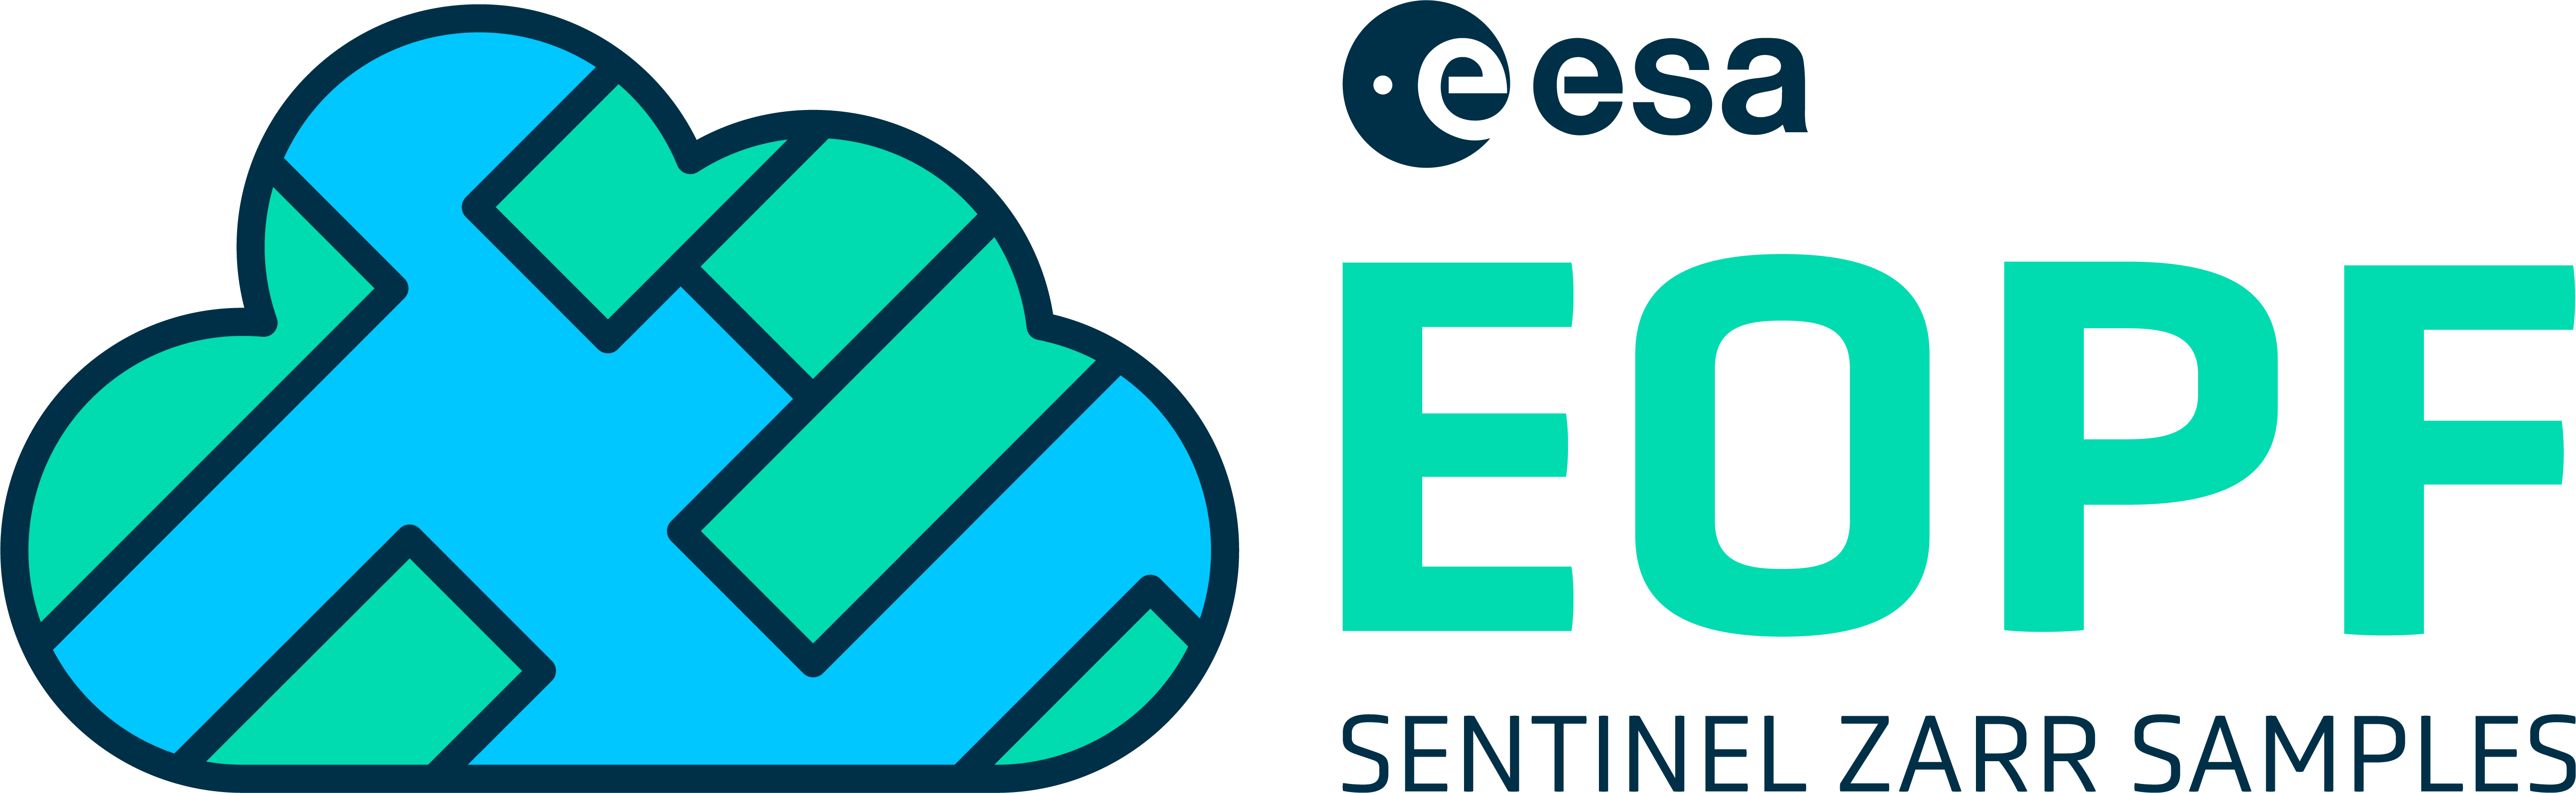

# Visualise EOPF ZARR Sentinel 2 files using GDAL

## Import Libraries

- GDAL: Geospatial Data Abstraction Library
- Numpy: Numerical Python
- Matplotlib: Python 2D plotting library

In [9]:
from osgeo import gdal

**Build the GDAL connection to the ZARR file**

Note: Always add **'ZARR:"/vsicurl/your_zarr_file_url'** to the ZARR file path

In [41]:
dsn = (
    'ZARR:"/vsicurl/https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2B_MSIL1C_20250113T103309_N0511_R108_T32TLQ_20250113T122458.zarr"'
)

**Open the dataset using GDAL’s Zarr driver.**

In [42]:
ds = gdal.Open(dsn, gdal.GA_ReadOnly)
if ds is None:
    raise RuntimeError("Failed to open the Zarr dataset with GDAL.")

In [43]:
# Check if the dataset was opened successfully
if ds is not None:
    print("Dataset opened successfully!")
    # Print metadata
    print(ds.GetMetadata())
else:
    print("Failed to open dataset.")

Dataset opened successfully!
{}


In [44]:
subds = ds.GetSubDatasets()
for idx, s in enumerate(subds):
    print(idx, s)

0 ('ZARR:"/vsicurl/https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2B_MSIL1C_20250113T103309_N0511_R108_T32TLQ_20250113T122458.zarr":/conditions/geometry/angle', 'Array /conditions/geometry/angle')
1 ('ZARR:"/vsicurl/https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2B_MSIL1C_20250113T103309_N0511_R108_T32TLQ_20250113T122458.zarr":/conditions/geometry/band', 'Array /conditions/geometry/band')
2 ('ZARR:"/vsicurl/https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2B_MSIL1C_20250113T103309_N0511_R108_T32TLQ_20250113T122458.zarr":/conditions/geometry/detector', 'Array /conditions/geometry/detector')
3 ('ZARR:"/vsicurl/https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2B_MSIL1C_20250113T103309_N0511_R108_T32TLQ_20250113T122458.zarr":/conditions/geometry/x', 'Array /conditions/geometry/

In [61]:
open_subds = gdal.Open(subds[80][0], gdal.GA_ReadOnly)
if open_subds is None:
    raise RuntimeError("Failed to open the Zarr dataset with GDAL.")

**Get the raster band (assuming there is one band).**

In [62]:
band = open_subds.GetRasterBand(1)
width = band.XSize
height = band.YSize
print("Original dimensions: {} x {}".format(width, height))

Original dimensions: 1830 x 1830


**Define decimation factors.**

In [63]:
factor = 10
new_width = width // factor
new_height = height // factor

**Use gdal.Warp to create an in-memory dataset that decimates the data using nearest neighbor.Nearest neighbor resampling is equivalent to taking every nth pixel.**

In [64]:
gdal.SetConfigOption("ZARR_ALLOW_BIG_TILE_SIZE", "YES")
decimated_ds = gdal.Warp(
    '',         # Output to an in-memory dataset.
    open_subds,         # Source dataset.
    format='MEM',
    width=new_width, height=new_height,
    resampleAlg='near'  # 'near' means nearest neighbor, so it just picks the pixel at the corresponding location.
)
if decimated_ds is None:
    raise RuntimeError("gdal.Warp failed to create decimated dataset.")

**Read the decimated data into a numpy array.**

In [65]:
data = decimated_ds.GetRasterBand(1).ReadAsArray()
print("Decimated dimensions: {} x {}".format(data.shape[1], data.shape[0]))

Decimated dimensions: 183 x 183


**Plot the decimated data using Matplotlib.**

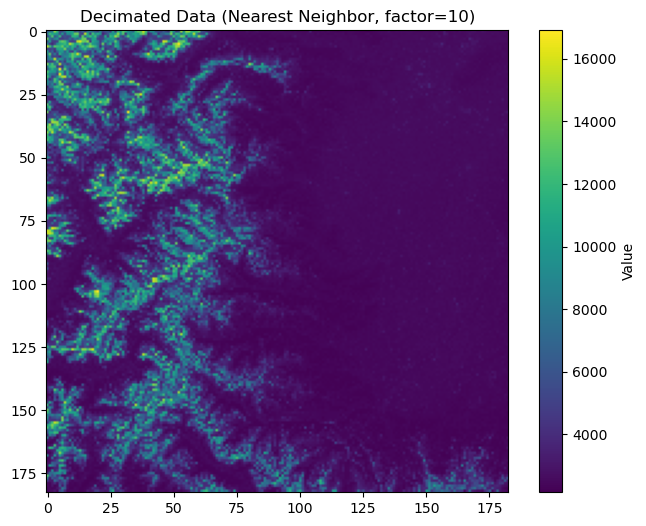

In [67]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.imshow(data)
plt.colorbar(label='Value')
plt.title('Decimated Data (Nearest Neighbor, factor=10)')

plt.show()